# 6.6 Time-series Forecasting

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [3]:
#establishing a path
path = r'C:\Users\harkn\OneDrive\Desktop\Tasks\Data Immersion\Achievement 6 - IndeGo BikeShare'

In [4]:
#importing dataframes
df = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', '11-1_cleaned_data_full.pkl'))

In [5]:
df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,...,start_station_name,end_station_name,trip_category_code,bike_type_code,start_date,start_time_of_day,end_date,end_time_of_day,start_point,end_point
0,579507686,70,2023-01-01 00:00:00,2023-01-01 01:10:00,3063,39.946331,-75.169800,3063,39.946331,-75.169800,...,17th & Pine,17th & Pine,0,1,2023-01-01,00:00:00,2023-01-01,01:10:00,"(39.946331, -75.1698)","(39.946331, -75.1698)"
1,579499091,17,2023-01-01 00:05:00,2023-01-01 00:22:00,3190,39.948921,-75.169907,3207,39.954411,-75.192001,...,17th & Locust,34th & Chestnut,1,0,2023-01-01,00:05:00,2023-01-01,00:22:00,"(39.948921, -75.169907)","(39.954411, -75.192001)"
2,579499089,11,2023-01-01 00:06:00,2023-01-01 00:17:00,3182,39.950809,-75.169533,3102,39.967590,-75.179520,...,17th & Sansom,Pennsylvania & Fairmount Perelman Building,1,1,2023-01-01,00:06:00,2023-01-01,00:17:00,"(39.950809, -75.169533)","(39.96759, -75.17952)"
3,579499087,1,2023-01-01 00:08:00,2023-01-01 00:09:00,3026,39.941818,-75.145500,3026,39.941818,-75.145500,...,2nd & Lombard,2nd & Lombard,0,1,2023-01-01,00:08:00,2023-01-01,00:09:00,"(39.941818, -75.1455)","(39.941818, -75.1455)"
4,579499085,27,2023-01-01 00:09:00,2023-01-01 00:36:00,3046,39.950119,-75.144722,3112,39.953732,-75.218246,...,2nd & Market,48th & Spruce,1,1,2023-01-01,00:09:00,2023-01-01,00:36:00,"(39.950119, -75.144722)","(39.953732, -75.218246)"


In [6]:
df.shape

(1084547, 25)

In [7]:
df.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type', 'start_station_name', 'end_station_name',
       'trip_category_code', 'bike_type_code', 'start_date',
       'start_time_of_day', 'end_date', 'end_time_of_day', 'start_point',
       'end_point'],
      dtype='object')

In [8]:
df_sub = df[['trip_id', 'duration', 'start_time', 'start_station', 'end_station', 'bike_id', 'trip_category_code', 'bike_type_code', ]]

In [9]:
df_sub.head()

,trip_id,duration,start_time,start_station,end_station,bike_id,trip_category_code,bike_type_code
0,579507686,70,2023-01-01 00:00:00,3063,3063,22584,0,1
1,579499091,17,2023-01-01 00:05:00,3190,3207,5281,1,0
2,579499089,11,2023-01-01 00:06:00,3182,3102,22366,1,1
3,579499087,1,2023-01-01 00:08:00,3026,3026,17780,0,1
4,579499085,27,2023-01-01 00:09:00,3046,3112,16897,1,1


In [10]:
# Ensure 'start_time' is converted to datetime, setting errors='coerce' to handle any invalid values
df_sub['start_time'] = pd.to_datetime(df_sub['start_time'], errors='coerce')

In [11]:
# Drop rows where 'start_time' is NaT (Not a Time), resulting from invalid datetime conversions
df_sub = df_sub.dropna(subset=['start_time'])

In [12]:
# Check for min and max values to verify they are within range
print("Min date:", df_sub['start_time'].min())
print("Max date:", df_sub['start_time'].max())

Min date: 2023-01-01 00:00:00
Max date: 2023-12-31 23:55:00


In [13]:
specific_value = -41067857.60063605  # The problematic date ordinal
result = df_sub[df_sub['start_time'] == specific_value]
print(result)

Empty DataFrame
Columns: [trip_id, duration, start_time, start_station, end_station, bike_id, trip_category_code, bike_type_code]
Index: []


In [14]:
df_sample = df_sub.head(50)  # Try an even smaller subset

In [15]:
date_columns = ['start_time'] 
for col in date_columns:
    df_sample[col] = pd.to_datetime(df_sample[col], errors='coerce')

In [16]:
for col in date_columns:
    print(f"Column: {col}")
    print("Non-datetime values:", df_sample[col].isna().sum())  # Check for any non-date values

Column: start_time
Non-datetime values: 0


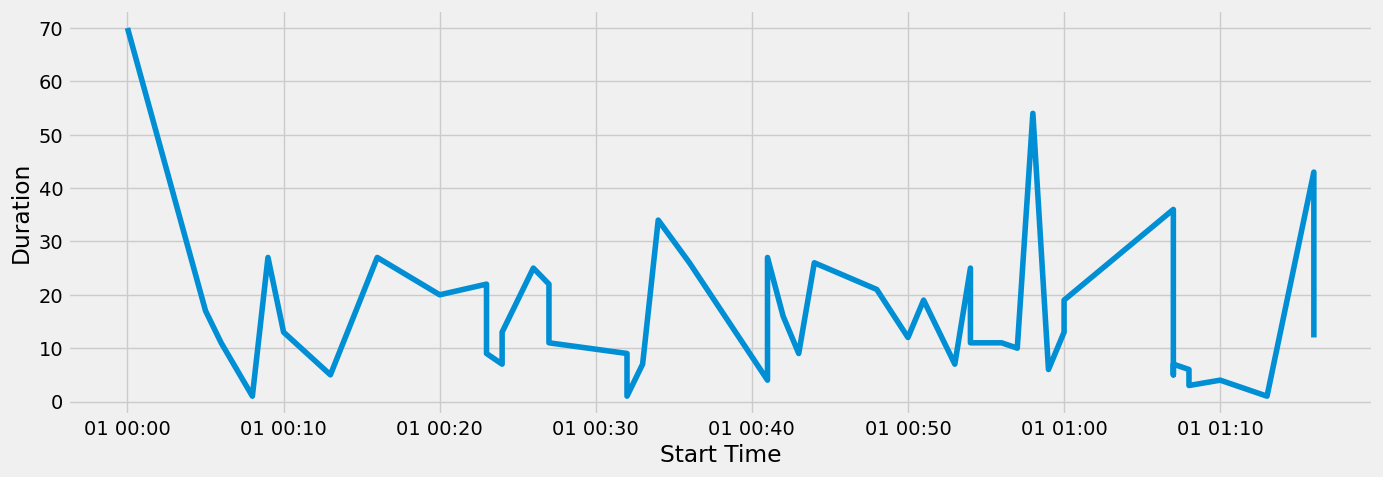

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(df_sample['start_time'], df_sample['duration'])  # Adjust as needed
plt.xlabel("Start Time")
plt.ylabel("Duration")
plt.show()

In [18]:
for col in date_columns:
    df_sub[col] = pd.to_datetime(df_sub[col], errors='coerce')

In [19]:
df_filtered = df_sub[(df_sub['start_time'] >= '2023-01-01') & (df_sub['start_time'] <= '2023-12-31')]

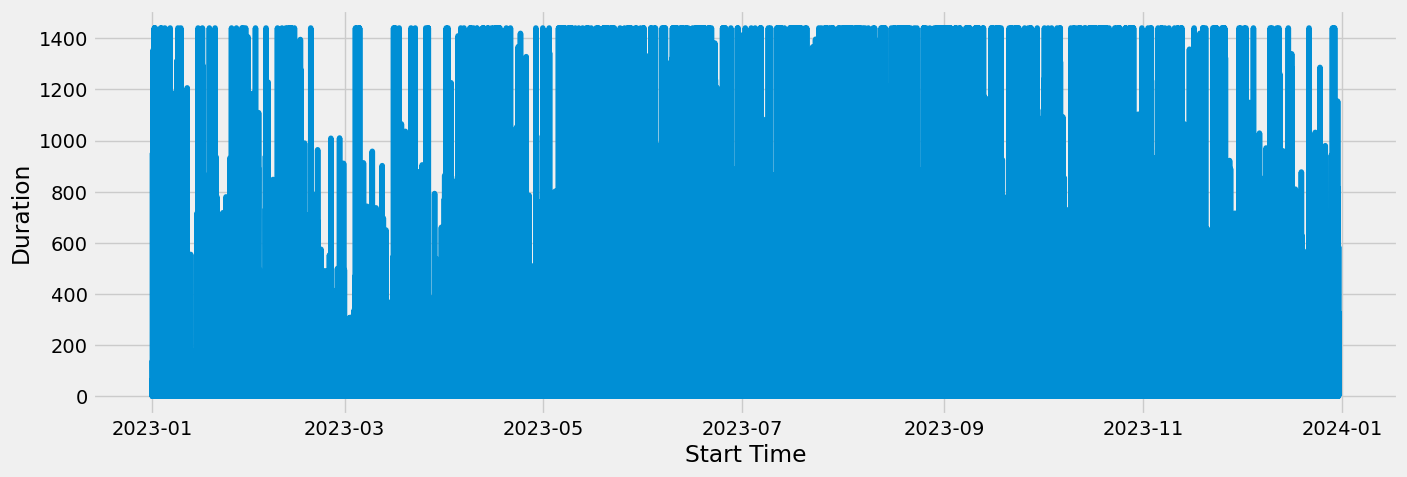

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(df_filtered['start_time'], df_filtered['duration'])
plt.xlabel("Start Time")
plt.ylabel("Duration")
plt.show()

In [21]:
# downsample the data for a weekly average
df_downsampled = df_filtered.resample('W', on='start_time').mean()  # Weekly average

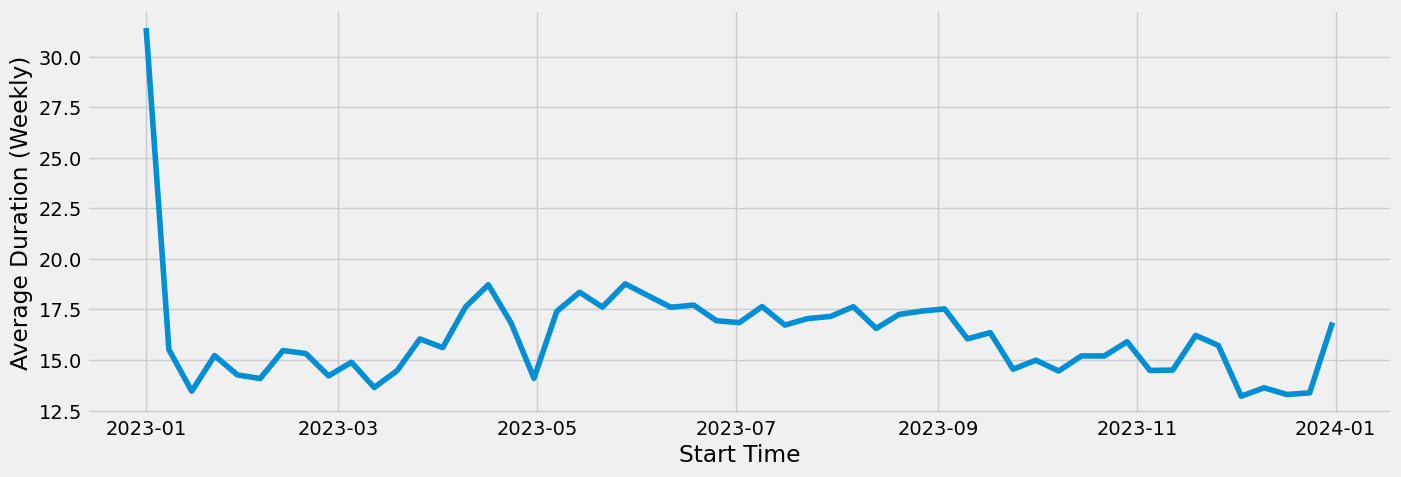

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(df_downsampled.index, df_downsampled['duration'])
plt.xlabel("Start Time")
plt.ylabel("Average Duration (Weekly)")
plt.show()

### Subsetting, wrangling and cleaning

In [24]:
# Reset index so that you can use the "Date" column as a filter

df_filtered = df_filtered.reset_index()

In [25]:
df_filtered.head()

,index,trip_id,duration,start_time,start_station,end_station,bike_id,trip_category_code,bike_type_code
0,0,579507686,70,2023-01-01 00:00:00,3063,3063,22584,0,1
1,1,579499091,17,2023-01-01 00:05:00,3190,3207,5281,1,0
2,2,579499089,11,2023-01-01 00:06:00,3182,3102,22366,1,1
3,3,579499087,1,2023-01-01 00:08:00,3026,3026,17780,0,1
4,4,579499085,27,2023-01-01 00:09:00,3046,3112,16897,1,1


In [26]:
data_sub = df_filtered.loc[(df_filtered['start_time'] >= '2023-01-01') & (df_filtered['start_time'] < '2023-12-31')]

In [27]:
data_sub.head()

,index,trip_id,duration,start_time,start_station,end_station,bike_id,trip_category_code,bike_type_code
0,0,579507686,70,2023-01-01 00:00:00,3063,3063,22584,0,1
1,1,579499091,17,2023-01-01 00:05:00,3190,3207,5281,1,0
2,2,579499089,11,2023-01-01 00:06:00,3182,3102,22366,1,1
3,3,579499087,1,2023-01-01 00:08:00,3026,3026,17780,0,1
4,4,579499085,27,2023-01-01 00:09:00,3046,3112,16897,1,1


In [28]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime_start'] = pd.to_datetime(data_sub['start_time']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime_start') # Set the datetime as the index of the dataframe.
data_sub.drop(['start_time'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,index,trip_id,duration,start_station,end_station,bike_id,trip_category_code,bike_type_code
datetime_start,,,,,,,,
2023-01-01 00:00:00,0,579507686,70,3063,3063,22584,0,1
2023-01-01 00:05:00,1,579499091,17,3190,3207,5281,1,0
2023-01-01 00:06:00,2,579499089,11,3182,3102,22366,1,1
2023-01-01 00:08:00,3,579499087,1,3026,3026,17780,0,1
2023-01-01 00:09:00,4,579499085,27,3046,3112,16897,1,1


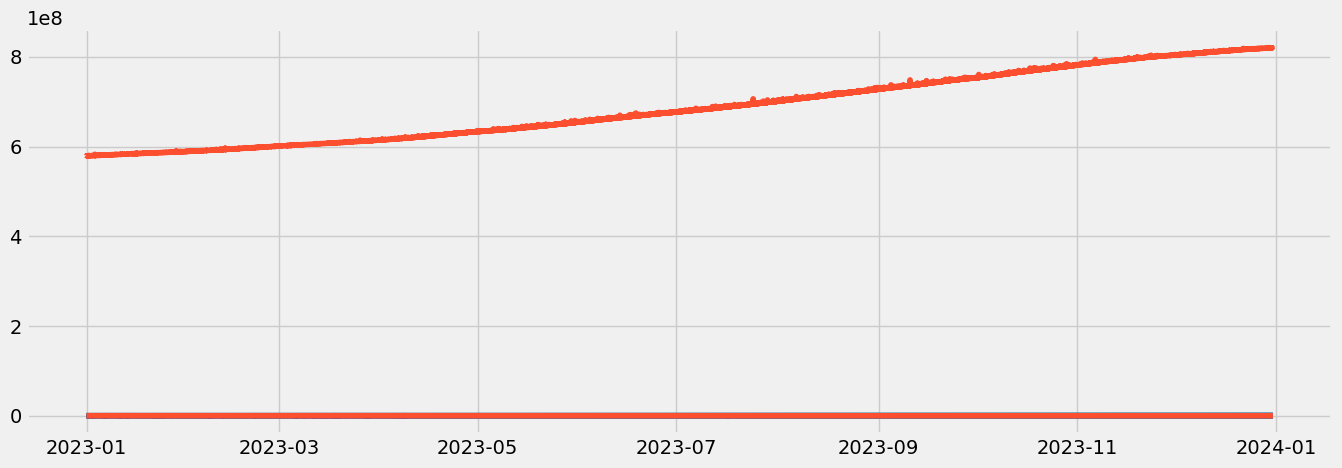

In [29]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

### Decomposition

In [31]:
# Check for missing values in each column
data_sub.isna().sum()
data_sub.head()

,index,trip_id,duration,start_station,end_station,bike_id,trip_category_code,bike_type_code
datetime_start,,,,,,,,
2023-01-01 00:00:00,0,579507686,70,3063,3063,22584,0,1
2023-01-01 00:05:00,1,579499091,17,3190,3207,5281,1,0
2023-01-01 00:06:00,2,579499089,11,3182,3102,22366,1,1
2023-01-01 00:08:00,3,579499087,1,3026,3026,17780,0,1
2023-01-01 00:09:00,4,579499085,27,3046,3112,16897,1,1


In [32]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub['duration'], model='additive', period=7)

In [33]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

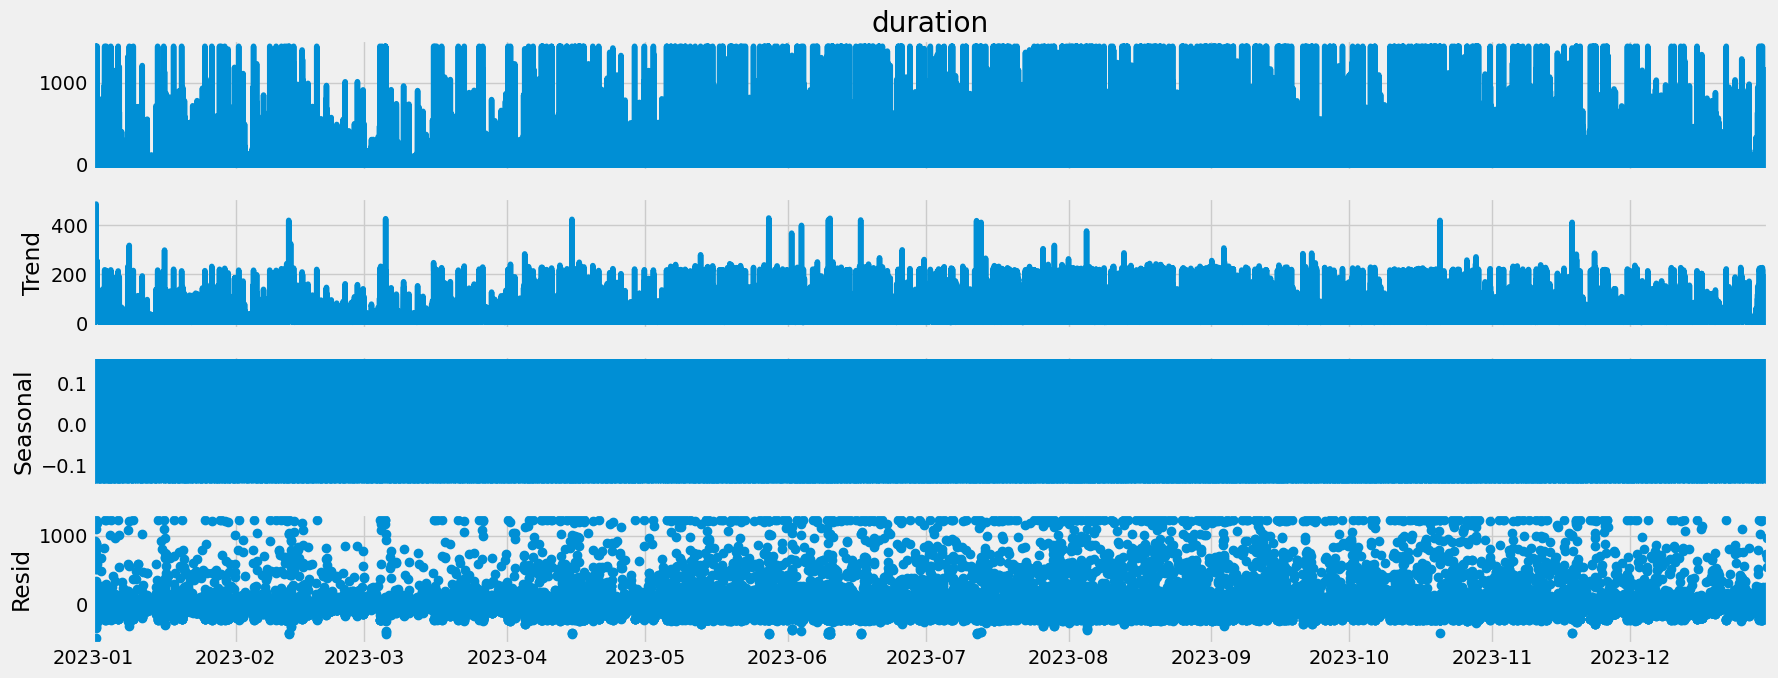

In [34]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Dickey Fuller Test

In [36]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag=None)
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['duration'])

Dickey-Fuller Stationarity test:
Test Statistic                -7.109916e+01
p-value                        0.000000e+00
Number of Lags Used            1.230000e+02
Number of Observations Used    1.082897e+06
Critical Value (1%)           -3.430356e+00
Critical Value (5%)           -2.861543e+00
Critical Value (10%)          -2.566771e+00
dtype: float64


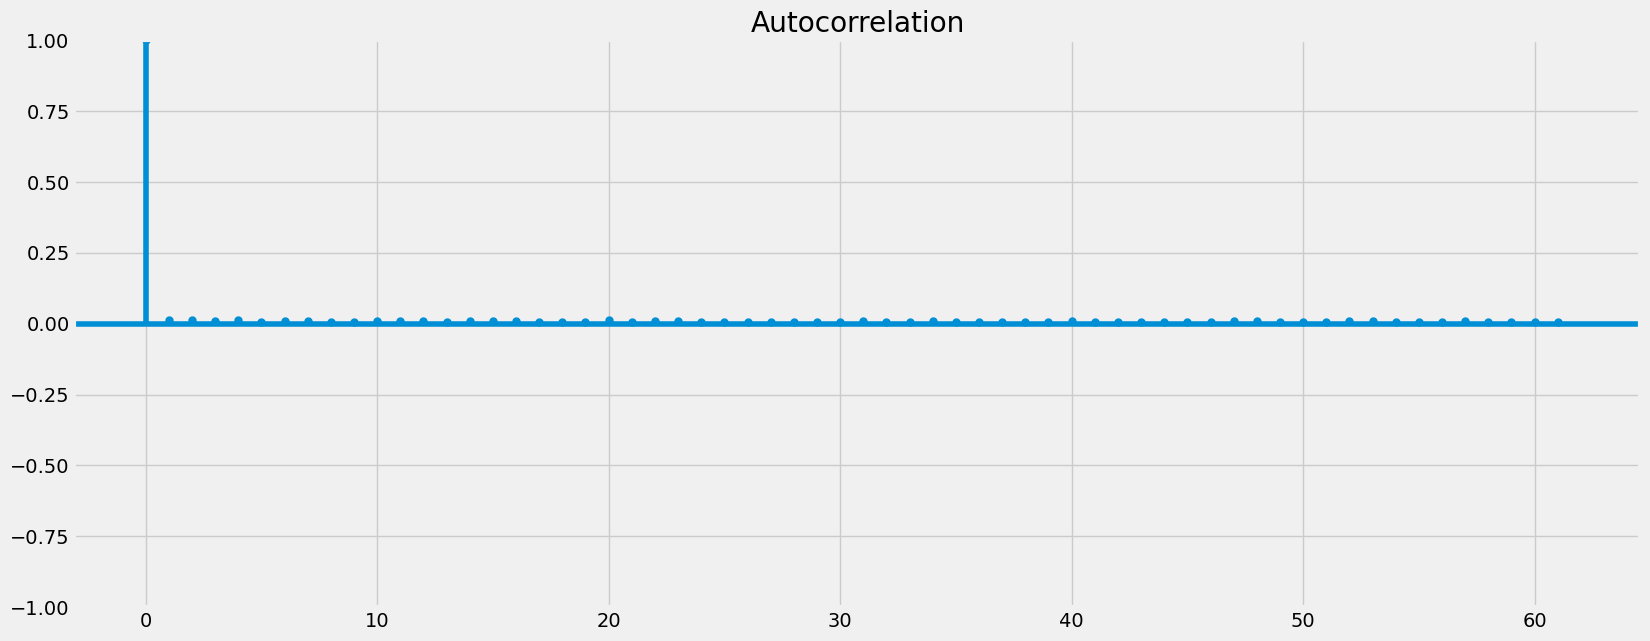

In [37]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub['duration'])
plt.show()

#### Stationarizing

The time series is stationary. The p-value is 0, which is a strong indicator of stationarity.